Решение соревнования на Kaggle:
https://www.kaggle.com/competitions/playground-series-s4e4/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_log_error, accuracy_score
import featuretools as ft
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from tqdm import tqdm
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data = train_data.drop(['id'], axis=1)
train_data = train_data.rename({'Whole weight': 'Whole_weight', 'Whole weight.1': 'Whole_weight_1', 'Whole weight.2': 'Whole_weight_2', 'Shell weight': 'Shell_weight'}, axis=1)
train_data = pd.get_dummies(train_data, columns=['Sex'], dtype=int)

In [4]:
train_data.drop(['Rings'], axis=1).columns.to_list()
indexes = set()
cols = train_data.drop(['Rings'], axis=1).columns.to_list()[:7]
for i in tqdm(range(len(cols))):
    for j in range(i+1, len(cols)):
        new_tr = train_data[[cols[i], cols[j]]]
        knn = NearestNeighbors(n_neighbors=300)
        knn.fit(new_tr)
        distances, indices = knn.kneighbors(new_tr)
        new_tr['knn'] = pd.Series(distances.mean(axis=1))
        indexes = indexes.union(set(new_tr['knn'].abs().nlargest(120).index.tolist()))

100%|██████████| 7/7 [02:40<00:00, 22.89s/it]


In [5]:
inds = np.array(list(set(np.arange(90615)) - indexes))
inds = np.array(list(inds))
tr = train_data.loc[inds, :].reset_index(drop=True)

Смысл данных операций в том, что мы исключаем из датасета выбросы, воспользовавшись KNN для этого. Самые дальние точки от общего набора данных считаем выбросами по каждой паре столбцов. Теоретико-множественное объединение всех таких наблюдений считаем общими выбросами. Пример выбросов:

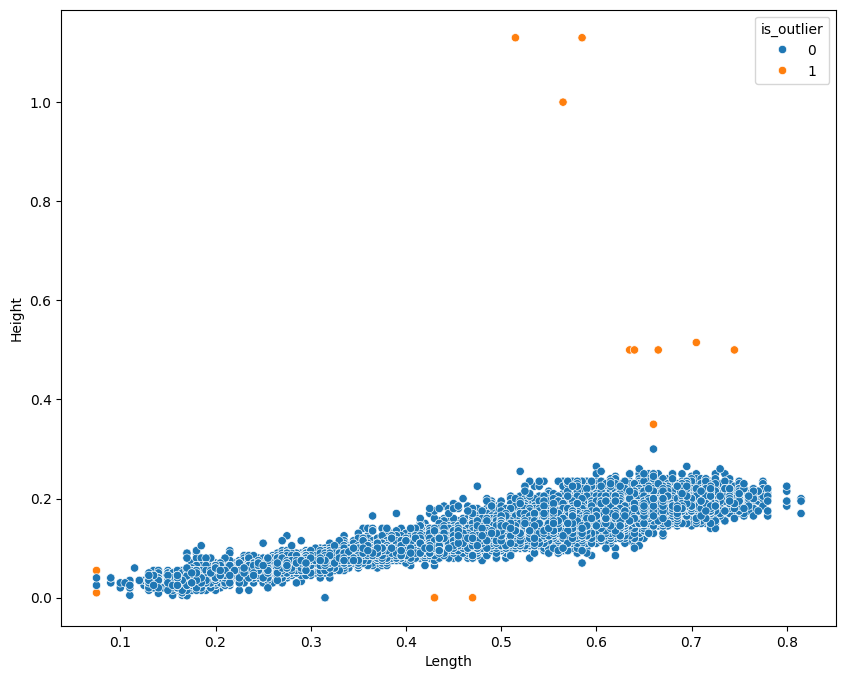

In [20]:
new_tr = train_data[['Length', 'Height']]
knn = NearestNeighbors(n_neighbors=300)
knn.fit(new_tr)
distances, indices = knn.kneighbors(new_tr)
new_tr['knn'] = pd.Series(distances.mean(axis=1))
indexes = set(new_tr['knn'].abs().nlargest(15).index.tolist())
new_tr['is_outlier'] = 0
new_tr['is_outlier'].iloc[list(indexes)] = 1
plt.figure(figsize=(10, 8))
sns.scatterplot(new_tr, x='Length', y='Height', hue='is_outlier')
plt.show()

In [6]:
tr.head()

,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0,1,0


In [7]:
test_data = pd.read_csv('test.csv')
test_data_target = test_data.id
test_data = test_data.drop(['id'], axis=1)
test_data = test_data.rename({'Whole weight': 'Whole_weight', 'Whole weight.1': 'Whole_weight_1', 'Whole weight.2': 'Whole_weight_2', 'Shell weight': 'Shell_weight'}, axis=1)
test_data = pd.get_dummies(test_data, columns=['Sex'], dtype=int)

In [8]:
knn = NearestNeighbors()
scal = StandardScaler()
new_data = scal.fit_transform(tr.drop(['Rings'], axis=1))
ts = scal.transform(test_data)
knn.fit(new_data)
distances, indices = knn.kneighbors(ts)
INDEX_ = np.array(list(set(list(indices[:, 0]))))

In [9]:
# Подбор гиперпараметров XGBRegressor с помощью optuna

def objective(trial):

    params = {
    'objective': 'reg:squarederror',
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'gamma': trial.suggest_float('gamma', 0, 5),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }

    model = xgb.train(params, X_train, num_boost_round=trial.suggest_int('n_estimators', 100, 1000))

    y_pred = model.predict(X_test)

    return np.sqrt(mean_squared_log_error(y_test, y_pred))

In [ ]:
inds_yes = np.where(np.isin(tr.index.to_numpy(), INDEX_, invert=True))
scal = StandardScaler()
X = scal.fit_transform(tr.drop(['Rings'], axis=1))
y = tr.Rings.to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = X[inds_yes], X[INDEX_], y[inds_yes], y[INDEX_]
X_train = xgb.DMatrix(X_train, label=y_train)
X_test = xgb.DMatrix(X_test, label=y_test)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print('Best Parameters:', study.best_params)
print('Best RMLSE:', study.best_value)

In [ ]:
#Лучшие результаты:

best_params = {'n_estimators': 775, 'max_depth': 11, 'learning_rate': 0.006, 
                  'subsample': 0.55, 'colsample_bytree': 0.9, 'gamma': 2.5, 'reg_alpha': 2.25, 'reg_lambda': 2.0}
best_params2 = {'n_estimators': 750, 'max_depth': 12, 
    'learning_rate': 0.006, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 3.25, 'reg_alpha': 3.25, 'reg_lambda': 3.5}
best_params3 = {'learning_rate': 0.00815893857663276, 'max_depth': 10, 'subsample': 0.5242047675438934, 'colsample_bytree': 0.6528492278680181, 
          'gamma': 2.801771411971102, 'reg_alpha': 4.289279058866012, 'reg_lambda': 4.5641053041787725, 'n_estimators': 707}
best_params4 = {'n_estimators': 730, 'max_depth': 14, 
                'learning_rate': 0.006, 'subsample': 0.6, 'colsample_bytree': 0.5, 'gamma': 3.5, 'reg_alpha': 2.5, 'reg_lambda': 2.5}
best_params5 = {'n_estimators': 740, 'max_depth': 14, 
                'learning_rate': 0.006, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 3.75, 'reg_alpha': 2.5, 'reg_lambda': 2.25}

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test_data.to_numpy())

model = xgb.XGBRegressor(**best_params)
model2 = xgb.XGBRegressor(**best_params2)
model3 = xgb.XGBRegressor(**best_params3)
model4 = xgb.XGBRegressor(**best_params4)
model5 = xgb.XGBRegressor(**best_params5)

model.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)
model4.fit(X, y)
model5.fit(X, y)

In [ ]:
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
y_pred4 = model4.predict(X_test)
y_pred5 = model5.predict(X_test)

In [ ]:
predictions = (y_pred + y_pred2 + y_pred3 + y_pred4 + y_pred5) / 5
submission = pd.concat((test_data_target, pd.DataFrame(predictions, columns=['Rings'])), axis=1)
submission.to_csv('submission_new.csv', index=False)

Результат: 0.14549
Место: 267/2608